In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_detail_plot(percentage, test = True, prefix = ""):

    try:
        df = pd.read_csv(prefix+"results/log_raw_{}perc_aAdaptive_lam1_tol0_damplim0.csv".format(percentage))
    except:
        df = pd.read_csv(prefix+"results/log_raw_{}perc_aAdaptive_lam1_tol0_damplim0.01.csv".format(percentage))

    if test:
        df = df.sort_values(by='Mistake', ascending=True)
        df = df.reset_index(drop=True)
        y = df["Mistake"]
        y_u = df["SSD"]
    else:
        df["rt_Gain"] = df["rt_SSD"] - df["rt_Mistake"]
        df = df.sort_values(by='rt_Mistake', ascending=True)
        df = df.reset_index(drop=True)
        y = df["rt_Mistake"]
        y_u = df["rt_SSD"]


    if test:
        retrained = df["Best"] 
    else:
        retrained = df["rt_Best"]
    #to dataframe
    retrained = pd.DataFrame(retrained)
    retrained.columns.values[0] = "NEW"
    # sort ascending
    # retrained = retrained.sort_values(by='NEW', ascending=True) # we want to keep the same order as for y and y_u


    obs = len(y)
    x = np.arange(1, obs+1)

    plt.figure(figsize=(20, 6))

    # Plotting vertical grey lines
    for i in range(obs):
        shift = 0.00

        if y[i] > y_u[i]:
            plt.plot([x[i]+shift, x[i]+shift], [y[i], y_u[i]], color='orange')
        else:
            plt.plot([x[i]+shift, x[i]+shift], [y[i], y_u[i]], color='blue')

    # Creating the scatter plot
    plt.scatter(x, y, color='orange', label='Baseline model trained on data with errors', marker = "x", linewidths=2)

    #plot the normal_accuracy with a dashed line
    plt.scatter(x, retrained["NEW"], color='grey', marker = ".", linewidths=2, label="Model trained on data excluding errors")
    plt.plot(x, retrained["NEW"], color='grey', linestyle='dashed')

    plt.scatter(x, y_u, color='blue', label='Unlearned model using ASSD on Baseline model', marker = "o")



    # Shade the area where 'Gain' is negative (less than 0)
    negative_gain_indices = df[df['Gain'] <= 0].index

    #plt.fill_between(x[negative_gain_indices], y[negative_gain_indices]*0+min(y), y_u[negative_gain_indices]*0+max(y_u), color='red', alpha=0.3)
    plt.fill_between(x, y, y_u, color='gray', alpha=0.3)

    # plot a horizontal line at 86% accuracy
    #plt.plot([0, obs], [82.5, 82.5], color='black', linestyle='dashed')
    #plt.plot([0, obs], [86.5, 86.5], color='black', linestyle='dashed')

    #plt.plot([0, obs], [83.5, 87.5], color='black', linestyle='dashed')



    # hide x ticks
    plt.xticks([])
    
    # Adding labels and title
    plt.xlabel('100 random scenarios with {}% data entry errors orderd by baseline model accuracy'.format(percentage))
    plt.ylabel('Model Accuracy [%]')
    plt.title('Unlearning performance on a baseline model trained on {}% data entry errors across 100 random error scenarios ({} data)'.format(percentage, "Test" if test else "Train"))
    
    plt.text(0.02, 0.8, '{}%'.format(percentage), fontsize=50, color='gray', alpha=0.2, transform=plt.gca().transAxes)

    # Adding legend in the bottom right
    plt.legend(loc='lower right')
    
    # Show plot
    plt.show()

    # Create a dataframe that shows the  following for Mistake, SSD; Best: | Name | Mean plus minus STD for Mistake | Median plus minus STD for rt_Mistake |

    #df = df.sort_values(by='Mistake', ascending=True)
    #df = df.reset_index(drop=True)
    


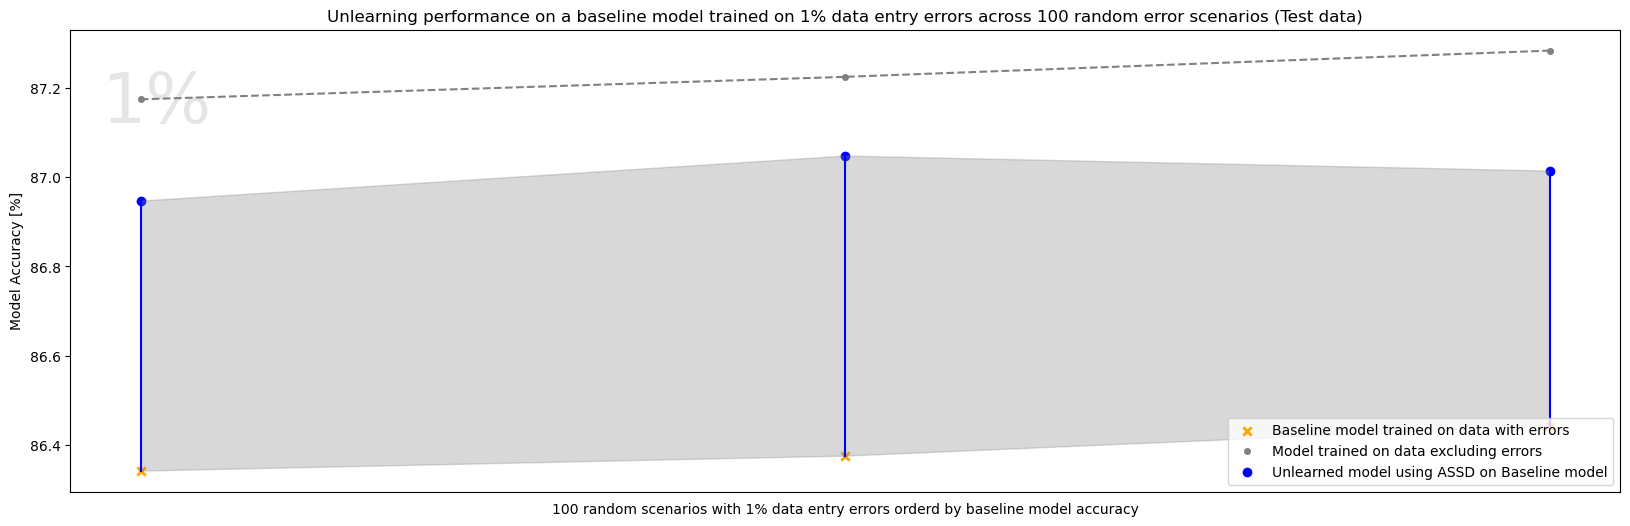

In [8]:

for percentage in [1]:
    try:
        get_detail_plot(percentage, test = True, prefix="small")
        #get_detail_plot(percentage, test = False)
    except:
        print("Error for {}% scenario; no data available".format(percentage))

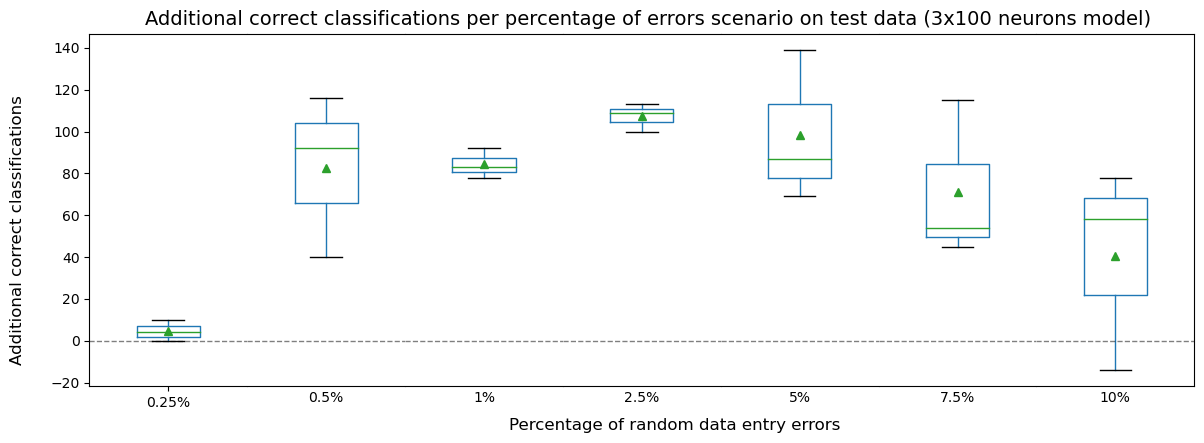

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def get_combined_plot():
    fig, axes = plt.subplots(1, 7, sharey=True, figsize=(13, 4))
    fig.subplots_adjust(top=0.99, wspace=-0, left = 0.05)  # Adjust the top spacing for the suptitle

    prefix = "small"
    percentages = [0.25, 0.5, 1, 2.5, 5, 7.5, 10]
    for i, percentage in enumerate(percentages):
        plt_df = pd.read_csv(prefix+"results/log_raw_{}perc_aAdaptive_lam1_tol0_damplim0.csv".format(percentage))
        plt_df.boxplot(column=['Add corr classifications'], showmeans=True, ax=axes[i], widths=0.4)

        #axes[i].set_title('{}%'.format(percentage), fontsize=12, pad=10)  # Add padding to the title
        axes[i].grid(False)
        axes[i].spines['right'].set_visible(False)
        #axes[i].spines['top'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_xticklabels([str(percentage) + "%"]) 
        if i != 0:
            axes[i].spines['left'].set_visible(False)
            axes[i].tick_params(axis='both', which='both', length=0)
            axes[i].set_ylabel('')
        if i == len(percentages)-1:
            axes[i].spines['right'].set_visible(True)
        

        # add a horizontal dashed line at 0
        axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

        # prefix to model size
    if prefix == "":
        prefix = "5x250"
    elif prefix == "small":
        prefix = "3x100"
    elif prefix == "verysmall":
        prefix = "2x50"
    else:
        prefix = "Unspecified"

    fig.suptitle('Additional correct classifications per percentage of errors scenario on test data ({} neurons model)'.format(prefix), fontsize=14, y=1.05, x=0.48)  # Adjust the y position of the suptitle
    fig.text(0.5, 0.0, 'Percentage of random data entry errors', ha='center', fontsize=12)
    fig.text(-0.011, 0.5, 'Additional correct classifications', va='center', rotation='vertical', fontsize=12)
    #plt.tight_layout()
    plt.show()

get_combined_plot()

# Table creation

In [10]:
import scipy.stats as stats
percentage_list = [1, 2.5, 5]
sig_level = 0.05

cols = ['Model size', 'Train/Test', 'Error %', 'Baseline Accuracy', 'Retrain Accuracy', 'FInetune Accuracy', 'Unlearn Accuracy', 'p-value Baseline-Unlearning'] # p value for Baseline vs Unlearned
# create an empty dataframe with the columns in cols
df_combined = pd.DataFrame(columns=cols)

prefix_list = ["small"] #["", "small", "verysmall"]  

for percentage in percentage_list:
    for prefix_i in prefix_list:
        df_i = pd.read_csv(prefix_i+"results/log_raw_{}perc_aAdaptive_lam1_tol0_damplim0.csv".format(percentage))

        # prefix to model size
        if prefix_i == "":
            prefix = "5x250"
        elif prefix_i == "small":
            prefix = "3x100"
        elif prefix_i == "verysmall":
            prefix = "2x50"
        else:
            prefix = "Unspecified"

        p_value = stats.ttest_ind(df_i["Mistake"], df_i["SSD"])[1]
        if p_value < sig_level:
            p_value = "<0.05"
        else:
            p_value = np.round(p_value, 2)

        # We add the pm accuracy values
        test_row = [prefix, "Test", percentage, f"{df_i['Mistake'].mean():.2f} ± {df_i['Mistake'].std():.2f}", f"{df_i['Best'].mean():.2f} ± {df_i['Best'].std():.2f}", f"{df_i['ft_Mistake'].mean():.2f} ± {df_i['ft_Mistake'].std():.2f}", f"{df_i['SSD'].mean():.2f} ± {df_i['SSD'].std():.2f}", p_value]
        df_combined = pd.concat([df_combined, pd.DataFrame([test_row], columns=cols)])

for percentage in percentage_list: 
    for prefix_i in prefix_list:
        df_i = pd.read_csv(prefix_i+"results/log_raw_{}perc_aAdaptive_lam1_tol0_damplim0.csv".format(percentage))

        # prefix to model size
        if prefix_i == "":
            prefix = "5x250"
        elif prefix_i == "small":
            prefix = "3x100"
        elif prefix_i == "verysmall":
            prefix = "2x50"
        else:
            prefix = "Unspecified"

        p_value = stats.ttest_ind(df_i["rt_Mistake"], df_i["rt_SSD"])[1]
        if p_value < sig_level:
            p_value = "<0.05"
        else:
            p_value = np.round(p_value, 2)

        # We add the pm accuracy values
        train_row = [prefix, "Train", percentage, f"{df_i['rt_Mistake'].mean():.2f} ± {df_i['rt_Mistake'].std():.2f}", f"{df_i['rt_Best'].mean():.2f} ± {df_i['rt_Best'].std():.2f}", f"{df_i['ft_rt_Mistake'].mean():.2f} ± {df_i['ft_rt_Mistake'].std():.2f}", f"{df_i['rt_SSD'].mean():.2f} ± {df_i['rt_SSD'].std():.2f}", p_value]
        df_combined = pd.concat([df_combined, pd.DataFrame([train_row], columns=cols)])

        
# round to two digits for all columns except the last one
df_combined.iloc[:, :-1] = df_combined.iloc[:, :-1].round(2)


# save as a csv file
df_combined.to_csv("combined_results.csv", index=False)

df_combined

,Model size,Train/Test,Error %,Baseline Accuracy,Retrain Accuracy,FInetune Accuracy,Unlearn Accuracy,p-value Baseline-Unlearning
0,3x100,Test,1,86.39 ± 0.05,87.23 ± 0.05,86.82 ± 0.10,87.00 ± 0.05,<0.05
0,3x100,Test,2.5,86.58 ± 0.06,86.81 ± 0.04,86.58 ± 0.06,87.37 ± 0.05,<0.05
0,3x100,Test,5,86.78 ± 0.11,86.71 ± 0.05,86.71 ± 0.09,87.50 ± 0.16,<0.05
0,3x100,Train,1,87.21 ± 0.06,87.56 ± 0.07,87.61 ± 0.07,87.33 ± 0.06,0.06
0,3x100,Train,2.5,87.26 ± 0.03,87.19 ± 0.02,87.25 ± 0.10,87.58 ± 0.18,<0.05
0,3x100,Train,5,87.31 ± 0.03,87.24 ± 0.04,87.32 ± 0.06,87.79 ± 0.16,<0.05
